In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
! pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 6.1 MB/s eta 0:00:00


In [3]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 64

In [4]:
data_dir = '/kaggle/input/sampah-daur-ulang/DATASETS'

In [5]:
def build_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=.20,
        subset=subset,
        label_mode="categorical",
        seed=123,
        image_size=IMAGE_SIZE,
        batch_size=1
    )

In [6]:
train_ds = build_dataset("training")

Found 6387 files belonging to 6 classes.
Using 5110 files for training.


In [7]:
class_names = tuple(train_ds.class_names)

In [8]:
train_size = train_ds.cardinality().numpy()

In [9]:
train_ds = train_ds.unbatch().batch(BATCH_SIZE)

In [10]:
train_ds = train_ds.repeat()

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

In [12]:
do_data_augmentation = True
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))

In [13]:
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

In [14]:
val_ds = build_dataset("validation")

Found 6387 files belonging to 6 classes.
Using 1277 files for validation.


In [15]:
val_size = val_ds.cardinality().numpy()

In [16]:
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

In [17]:
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

In [18]:
feature_vector = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

In [19]:
def create_model():
    
  model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
      hub.KerasLayer(feature_vector, trainable=False),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(6,activation='softmax')
  ])

  
  model.compile(optimizer=RMSprop(lr=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    
  return model

In [20]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = val_size // BATCH_SIZE

In [22]:
history = model.fit(train_ds,
                    epochs=50, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds,
                    validation_steps=validation_steps).history

Epoch 1/50
79/79 [==============================] - 131s 2s/step - loss: 1.3606 - accuracy: 0.4972 - val_loss: 0.6683 - val_accuracy: 0.7673
Epoch 2/50
79/79 [==============================] - 115s 1s/step - loss: 0.8884 - accuracy: 0.6776 - val_loss: 0.5295 - val_accuracy: 0.8174
Epoch 3/50
79/79 [==============================] - 113s 1s/step - loss: 0.7714 - accuracy: 0.7239 - val_loss: 0.4593 - val_accuracy: 0.8347
Epoch 4/50
79/79 [==============================] - 111s 1s/step - loss: 0.7147 - accuracy: 0.7457 - val_loss: 0.4194 - val_accuracy: 0.8512
Epoch 5/50
79/79 [==============================] - 113s 1s/step - loss: 0.6855 - accuracy: 0.7513 - val_loss: 0.4025 - val_accuracy: 0.8553
Epoch 6/50
79/79 [==============================] - 112s 1s/step - loss: 0.6796 - accuracy: 0.7547 - val_loss: 0.4010 - val_accuracy: 0.8668
Epoch 7/50
79/79 [==============================] - 111s 1s/step - loss: 0.6584 - accuracy: 0.7654 - val_loss: 0.4149 - val_accuracy: 0.8668
Epoch 8/50
79

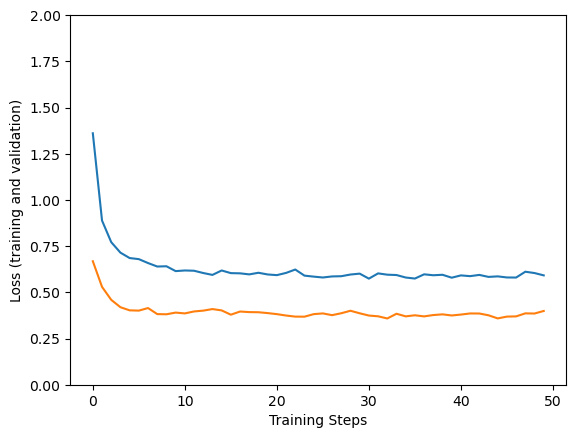

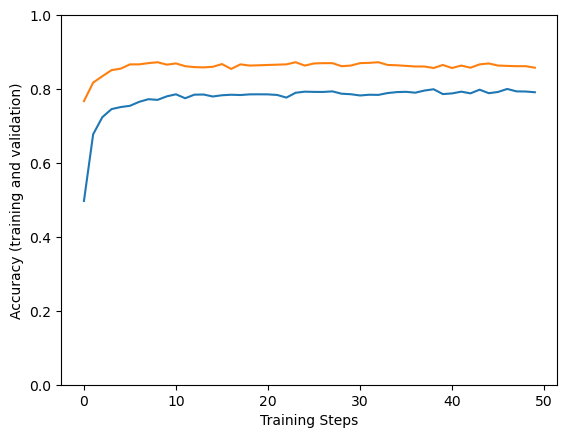

In [23]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["loss"])
plt.plot(history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

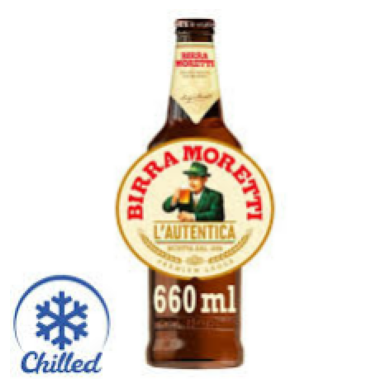

1/1 [==============================] - 1s 967ms/step
True label: Kaca
Predicted label: Kaca


In [24]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [25]:
saved_model_path = "/kaggle/working/saved_model"
tf.saved_model.save(model, saved_model_path)

In [26]:
model.save("model_v3.h5")

In [27]:
! zip -r ./model_v3.zip ./saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 92%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 78%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
